# Machine Learning: Clustering

Material for the [2018 Asterics and Obelics School](https://indico.in2p3.fr/event/16864/): [Table of Contents](Contents.ipynb)

Content is maintained on [github](https://github.com/Asterics2020-Obelics/School2018/tree/master/machinelearning) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

![sponsor-logos](img/sponsor-logos.png)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
from mls import display_gmm

## SciKit Learn

This will be our first time using the [SciKit Learn package](http://scikit-learn.org/stable/).  We don't include it in our standard preamble since it contains many modules (sub-packages).  Instead, we import each module as we need it, like this:

In [3]:
from sklearn import cluster, mixture

## Find Structure in Data

The type of structure we can look for is "clusters" of "nearby" samples, but the definition of both of these terms requires some care.

Clustering algorithms perform **unsupervised learning**, with all features treated equally. Contrast this with supervised learning, where some "label" features are singled out for learning from training data.

An advantage of unsupervised ML is that it works with any input data, and can discover patterns that you might not already know about.  Even when you have labeled training data available, an unsupervised algorithm can still be useful.

The disadvantage of unsupervised learning is that we cannot formulate objective measures for how well an algorithm is performing, so the results are always somewhat subjective.

### When are samples "nearby"?

In the simplest case, all features $x_{ij}$ have the same (possibly dimensionless) units, and the natural distance between samples (rows) $j$ and $k$ is:
$$
d(j, k) = \sum_{\text{features}\,i} (x_{ji} - x_{ki})^2 \; .
$$
However, what if some columns have different units?  For example, what is the distance between:
$$
\left( 1.2, 0.4~\text{cm}, 5.2~\text{kPa}\right)
$$
and
$$
\left( 0.7, 0.5~\text{cm}, 4.9~\text{kPa}\right)
$$
ML algorithms are generally unit-agnostic, so will happily combine features with different units but that may not be what you really want.

One reasonable solution is to normalize each feature with the [whitening transformation](https://en.wikipedia.org/wiki/Whitening_transformation):
$$
x \rightarrow (x - \mu) / \sigma
$$
where $\mu$, $\sigma$ are the mean and standard deviation of the original feature values.  In other words, you use the data itself to determine its natural origin $\mu$ and scale $\sigma$. The [sklearn.preprocessing module](http://scikit-learn.org/stable/modules/preprocessing.html) has helper functions to automate transformations like this.

### What is a "cluster" of samples?

In the simplest case (a), clusters are well separated by a line (in 2D, or hyperplane in more dimensions) and can be unambiguously identified by looking only at the distance between pairs of samples.

In practice, clusters might overlap leading to ambiguities (b), or the clusters we expect to find might require considering groups of more than two samples at a time (c), or might have a non-linear separation boundary (d).
![Examples of clustering](img/cluster_types.png)

Load these four datasets for working with below:

In [4]:
a_data = pd.read_hdf('data/cluster_a.hf5')
b_data = pd.read_hdf('data/cluster_b.hf5')
c_data = pd.read_hdf('data/cluster_c.hf5')
d_data = pd.read_hdf('data/cluster_d.hf5')

## K-means Clustering

The [K-means algorithm](https://en.wikipedia.org/wiki/K-means_clustering) is fast and robust, but assumes that your data consists of roughly round clusters of the same size (where the meanings of "round" and "size" depend on how your data is scaled).

Most sklearn algorithms use a similar calling pattern:
```
result = module.ClassName(..args..).fit(data)
```

For the [KMeans algorithm](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans):

In [5]:
a_fit = cluster.KMeans(n_clusters=2).fit(a_data)

We will use the following function to display 2D cluster results (don't worry about the [details](https://seaborn.pydata.org/tutorial/color_palettes.html) unless you are interested):

In [6]:
def plot_clusters(data, fit, xsize=9, ysize=5, ax=None):
    ax = ax or plt.gca()
    n_clusters = len(np.unique(fit.labels_))
    # Pick good colors to distinguish the different clusters.
    import matplotlib.colors
    cmap = matplotlib.colors.ListedColormap(
        sns.color_palette('husl', n_clusters).as_hex())
    ax.scatter(data.iloc[:, 0], data.iloc[:, 1], s=10, c=fit.labels_, cmap=cmap)
    # Use standard axes to match the plot above.
    ax.set_xlim(-xsize, +xsize)
    ax.set_ylim(-ysize, +ysize)
    ax.set_aspect(1.)

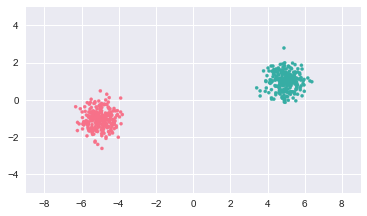

In [7]:
plot_clusters(a_data, a_fit)

Let's use KMeans to fit the three other (b,c,d) 2D datasets with `n_clusters=2` and generate similar plots. Which fits give the expected results?

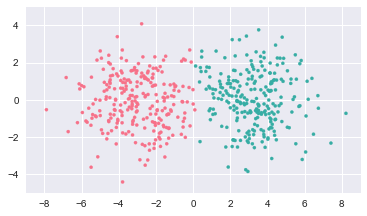

In [8]:
b_fit = cluster.KMeans(n_clusters=2).fit(b_data)
plot_clusters(b_data, b_fit)

The fit results look reasonable for (b), although the sharp dividing line between the two clusters looks artificial.

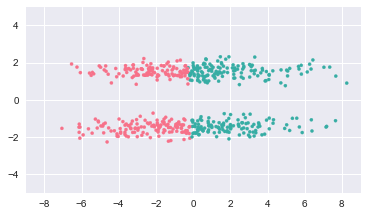

In [9]:
c_fit = cluster.KMeans(n_clusters=2).fit(c_data)
plot_clusters(c_data, c_fit)

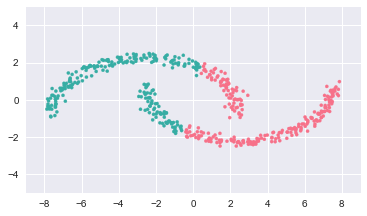

In [10]:
d_fit = cluster.KMeans(n_clusters=2).fit(d_data)
plot_clusters(d_data, d_fit)

The fit results for (c) and (d) do not match what we expect because KMeans only considers one pair at a time, so cannot identify larger scale patterns that are obvious by eye.

We have focused on KMeans as a prototypical clustering algorithm, but there are [many others to chose from](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html).  For example, [spectral clustering](https://en.wikipedia.org/wiki/Spectral_clustering) can handle (c) and (d), but has more parameters to tune:

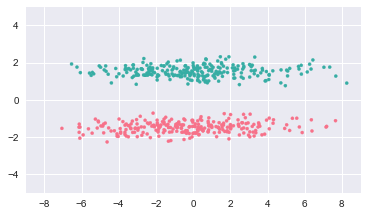

In [11]:
c_fit = cluster.SpectralClustering(n_clusters=2, gamma=0.5).fit(c_data)
plot_clusters(c_data, c_fit)

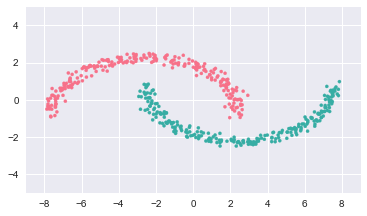

In [12]:
d_fit = cluster.SpectralClustering(n_clusters=2, gamma=2.0).fit(d_data)
plot_clusters(d_data, d_fit)

### Algorithm Hyperparameters

Algorithms have many parameters that influence their results for a given dataset, but these fall into two categories:
- Parameters whose values are determined by the data during the fitting process.
- Parameters which must be externally set.

The second group are **algorithm hyperparameters**. Since they influence your results (by definition), you need a procedure to set their values. This is formally a **model selection** problem that is usually solved using the **cross-validation** method we will learn soon.

**DISCUSS:** Are all of the arguments of the [KMeans constructor](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) hyperparameters?

In principle, yes, but in practice some of these arguments will have no (or minimal) impact on the algorithm result under normal conditions.  The arguments that are most clearly hyperparameters are:
- `n_clusters`, `algorithm`, `tol`

The arguments that are most clearly not hyperparameters are:
- `verbose`, `precompute_distances`, `n_jobs`

The remaining arugments are in the gray area.  In general, it is prudent to experiment with your actual data to identify which arguments affect your results significantly.

Compare fits to dataset (b) with `n_clusters` set to 2 or 3. Which do you think is the "true" number of clusters?  How might you decide between 2 and 3 more objectively?

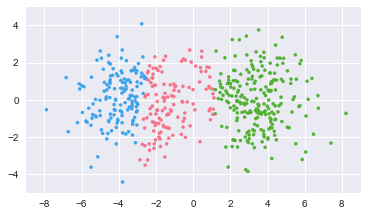

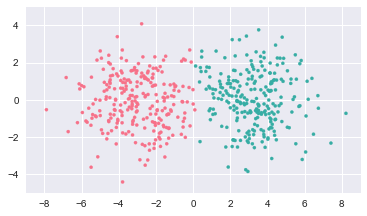

In [13]:
b_fit_3 = cluster.KMeans(n_clusters=3).fit(b_data)
plot_clusters(b_data, b_fit_3); plt.show()
plot_clusters(b_data, b_fit)

These plots make a convincing case (to me, at least) that there could be three clusters.  However, the "truth" in this case is two clusters.

This illustrates the dangers of superimposing a fit result on your data: it inevitably "draws your eye" and makes the fit more credible. Look out for examples of this when reading papers or listening to talks!

### Clustering in many dimensions

An algorithm to find clusters in 2D data is just automating what you could already by eye.  However, most clustering algorithms also work well with higher dimensional data, where the clusters might not be visible in any single 2D projection.

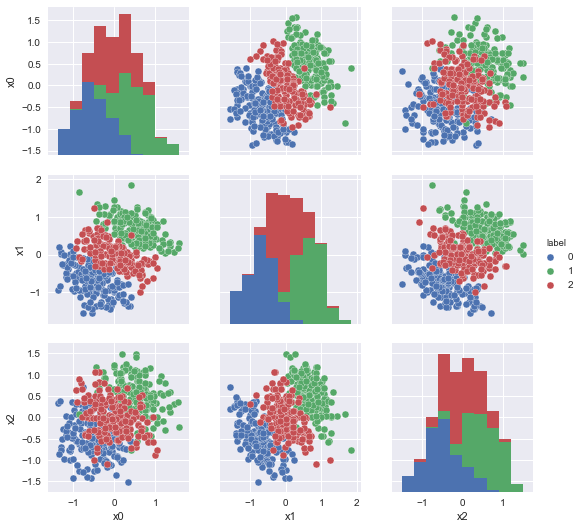

In [14]:
cluster_3d = pd.read_hdf('data/cluster_3d.hf5')
fit_3d = cluster.KMeans(n_clusters=3).fit(cluster_3d)
cluster_3d['label'] = fit_3d.labels_
sns.pairplot(cluster_3d, vars=('x0', 'x1', 'x2'), hue='label');

These clusters look quite arbitrary in each of the 2D scatter plots. However, they are actually very well separated, as we can see if we rotate the axes...

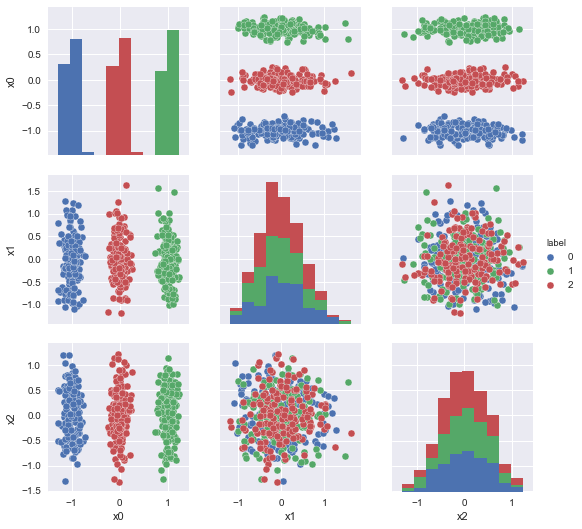

In [15]:
R = np.array([[0.5, -0.5, -0.707], [0.707, 0.707, 0.], [0.5, -0.5,0.707]])
rotated_3d = cluster_3d.copy()
rotated_3d[['x0', 'x1', 'x2']] = cluster_3d[['x0', 'x1', 'x2']].dot(R)
sns.pairplot(rotated_3d, vars=('x0', 'x1', 'x2'), hue='label');

This example is contrived, but the lesson is that clustering algorithms can discover higher-dimensional structure that you might miss with visualization.

## Overlapping Clusters

A basic clustering algorithm assigns each sample to a single cluster, but this assignment is ambiguous when clusters overlap. Instead, we would like an algorithm to tell us the probability that a sample belongs to each identified cluster. To estimate these probabilities, we need a model of the probability density within each cluster.

Read some of the data we generated earlier:

In [16]:
sources_4 = pd.read_hdf('data/sources_4_xy.hf5')
sources_5 = pd.read_hdf('data/sources_5_xy.hf5')
sources_8 = pd.read_hdf('data/sources_8_xy.hf5')

Fit each of these samples using KMeans with `n_clusters=1, 2, 3`:

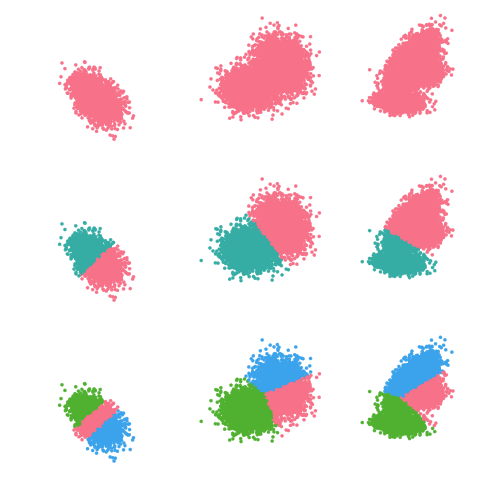

In [17]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(7, 7))
for col, X in enumerate((sources_4, sources_5, sources_8)):
    for row, n in enumerate((1, 2, 3)):
        fit = cluster.KMeans(n_clusters=n).fit(X)
        plot_clusters(X, fit, xsize=10, ysize=10, ax=ax[row, col])
        ax[row, col].axis('off')
plt.tight_layout()

### Gaussian Clusters

A convenient model is that each cluster is a [multivariate Gaussian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) in $D$ dimensions with probability density:
$$
G(\vec{x} ; \vec{\mu}, C) = \left(2\pi\right)^{-D/2}\,\left| C\right|^{-1/2}\,
\exp\left[  -\frac{1}{2} \left(\vec{x} - \vec{\mu}\right)^T C^{-1} \left(\vec{x} - \vec{\mu}\right) \right] \; ,
$$
where $\vec{\mu}$ determine the cluster centroid and the $D\times D$ positive definite covariance matrix $C$ determines its size and shape.

**EXERCISE:** How many independent parameters does a single Gaussian cluster have?

**ANSWER:** The mean vector $\vec{\mu}$ has $D$ independent parameters.  The covariance matrix $C$ has $D(D+1)/2$ independent parameters, due to the positive definite requirement, which implies $C^T = C$. Therefore the total number of parameters is:
$$
D + \frac{1}{2} D(D + 1) = \frac{1}{2} D (D + 3) \; .
$$

### Gaussian Mixture Model

A Gaussian Mixture Model (GMM) describes $K$ possibly overlapping clusters with a combined probability density
$$
P(\vec{x}) = \sum_{k=1}^{K}\, \omega_k\, G(\vec{x} ; \vec{\mu}_k, C_k) \; ,
$$
where the $K$ weights $\omega_k$ are normalized:
$$
\sum_{k=1}^K\, \omega_k = 1 \; .
$$

**EXERCISE:** How many parameters does a GMM need to describe 2D data ($D=2$) with $K = 1, 2, 3$?

**ANSWER:** Only $K - 1$ of the $K$ weights are independent because of the normalization condition, so the total number of parameters is:
$$
K - 1 + \frac{1}{2} K D (D + 3) \; .
$$
For $D = 2$, this simplifies to $6 K  - 1$, so the answers are 5 ($K=1$), 11 ($K=2$) and 17 ($K=3$).

This is a lot of parameters to be fit to a non-linear model, but fortunately we can use [Expectation Maximization](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) (EM) to efficiently and robustly find a (local) maximum likelihood solution. (The KMeans algorithm also uses EM, and GMM uses KMeans to initialize its parameters). 

GMM is not primarily a clustering algorithm and is better described as a parametric [density estimator](). However, since it models data as a mixture of Gaussian blobs, it is also useful for identifying clusters.

The [sklearn GMM implementation](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) uses the familiar calling pattern with the number of designed components $K$ as its main hyperparameter:

In [18]:
fit = mixture.GaussianMixture(n_components=3).fit(sources_8)

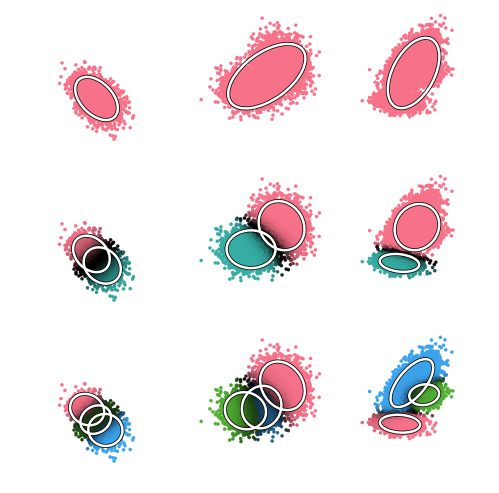

In [19]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(7, 7))
for col, X in enumerate((sources_4, sources_5, sources_8)):
    for row, n in enumerate((1, 2, 3)):
        fit = mixture.GaussianMixture(n_components=n).fit(X)
        display_gmm(X, fit, xsize=10, ysize=10, ax=ax[row, col])
        ax[row, col].axis('off')
plt.tight_layout()

In these plots, ellipses show the fitted 2D Gaussian components and darker colors identify regions where cluster assignments are ambiguous (as measured by the relative entropy of the cluster assignment probabilities).

This is all fine if you know in advance how many sources the data contains, but you usually don't for interesting problems.

In the hands-on session, you will explore a popular method to let the data tell you how many Gaussian clusters are present.

### Acknowledgement:
**H2020-Astronomy ESFRI and Research Infrastructure Cluster (Grant Agreement number: 653477).**